<a href="https://colab.research.google.com/github/anamika1302/Few-Shot-Learning-Setfit-Model/blob/main/Few_Shot_Learning_using_SetFit_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install setfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import wandb
import sklearn
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn import preprocessing
from setfit import SetFitModel, SetFitTrainer
from sklearn.model_selection import train_test_split
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments,Trainer,DataCollatorWithPadding,EarlyStoppingCallback

#### **Loading Dataset**

In [ ]:
df_sub_interactions = pd.read_csv("/content/drive/MyDrive/substance_interactions.csv")
df_sub_interactions

,PREDICATION_ID,PMID,PREDICATE,INDICATOR_TYPE,PREDICATE_START_INDEX,PREDICATE_END_INDEX,SUBJECT_TEXT,SUBJECT_SEMTYPE,SUBJECT_START_INDEX,SUBJECT_END_INDEX,...,OBJECT_START_INDEX,OBJECT_END_INDEX,OBJECT_SCORE,OBJECT_DIST,OBJECT_MAXDIST,OBJECT_CUI,OBJECT_NOVELTY,TYPE,SENTENCE,LABEL
0,P3100,6499897,INTERACTS_WITH,NOM,1298,1304,SA,orch,1235,1237,...,1329,1332,1000,2,2,C0004057,1,ab,"Nor did administration of SA, diflunisal or AS...",n
1,P3101,8369307,INHIBITS,VERB,890,899,rHF,aapp,785,788,...,912,919,888,1,15,C0242417,1,ab,A comparative study of recombinant L-cha...,n
2,P3102,3711333,INHIBITS,VERB,1527,1534,alkaloids,orch,1508,1517,...,1541,1550,1000,1,1,C0003805,1,ab,These findings suggest that some nicotinic alk...,y
3,P3103,11742534,INTERACTS_WITH,NOM,746,753,amino acids,aapp,703,714,...,741,745,694,0,4,C0169658|3716,1,ab,With a truncated chimaeric IL-5Rbeta-gp1...,y
4,P3104,244385,STIMULATES,ADJ,410,419,Neutral endopeptidase,aapp,374,401,...,480,491,1000,3,5,C0039815,1,ab,"Neutral endopeptidase, a zinc-dependent ...",n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,P6095,5660630,STIMULATES,VERB,843,850,benzaldehyde,orch,830,842,...,851,879,1000,1,2,C0053288,1,ab,Growth on benzyl alcohol or benzaldehyde...,y
2996,P6096,5660630,STIMULATES,VERB,843,850,benzyl alcohol,orch,806,826,...,851,879,1000,1,2,C0053288,1,ab,Growth on benzyl alcohol or benzaldehyde...,y
2997,P6097,5660630,STIMULATES,VERB,843,850,benzyl alcohol,orch,806,826,...,919,932,750,2,2,C0030016,1,ab,Growth on benzyl alcohol or benzaldehyde...,y
2998,P6098,14058290,INTERACTS_WITH,NOM,147,154,17-BETA-ESTRADIOL,horm,167,184,...,200,208,1000,4,5,C0033684,1,ti,"[ON THE BINDING OF ESTRONE, 17-BETA-ESTRADIOL ...",y


#### **Checking null values in dataset**

In [ ]:
df_sub_interactions.isna().sum(axis=0).reset_index()

,index,0
0,PREDICATION_ID,0
1,PMID,0
2,PREDICATE,0
3,INDICATOR_TYPE,0
4,PREDICATE_START_INDEX,0
5,PREDICATE_END_INDEX,0
6,SUBJECT_TEXT,0
7,SUBJECT_SEMTYPE,0
8,SUBJECT_START_INDEX,0
9,SUBJECT_END_INDEX,0


In [ ]:
df_sub_interactions.columns

Index(['PREDICATION_ID', 'PMID', 'PREDICATE', 'INDICATOR_TYPE',
       'PREDICATE_START_INDEX', 'PREDICATE_END_INDEX', 'SUBJECT_TEXT',
       'SUBJECT_SEMTYPE', 'SUBJECT_START_INDEX', 'SUBJECT_END_INDEX',
       'SUBJECT_SCORE', 'SUBJECT_DIST', 'SUBJECT_MAXDIST', 'SUBJECT_CUI',
       'SUBJECT_NOVELTY', 'OBJECT_TEXT', 'OBJECT_SEMTYPE',
       'OBJECT_START_INDEX', 'OBJECT_END_INDEX', 'OBJECT_SCORE', 'OBJECT_DIST',
       'OBJECT_MAXDIST', 'OBJECT_CUI', 'OBJECT_NOVELTY', 'TYPE', 'SENTENCE',
       'LABEL'],
      dtype='object')

In [ ]:
#taking only subset of columns
df_sub_interactions_final = df_sub_interactions[['SENTENCE','SUBJECT_TEXT','OBJECT_TEXT','PREDICATE','LABEL']]

#### **Word distribution across all sentences in dataframe**

In [ ]:
df_sub_interactions_final.loc[:,'word_count'] = df_sub_interactions_final['SENTENCE'].apply(lambda x: len(str(x).split()))

<ipython-input-16-858b7c1edaa4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_interactions_final.loc[:,'word_count'] = df_sub_interactions_final['SENTENCE'].apply(lambda x: len(str(x).split()))


Text(0.5, 1.0, 'word distribution across sentences.')

<Figure size 300x300 with 0 Axes>

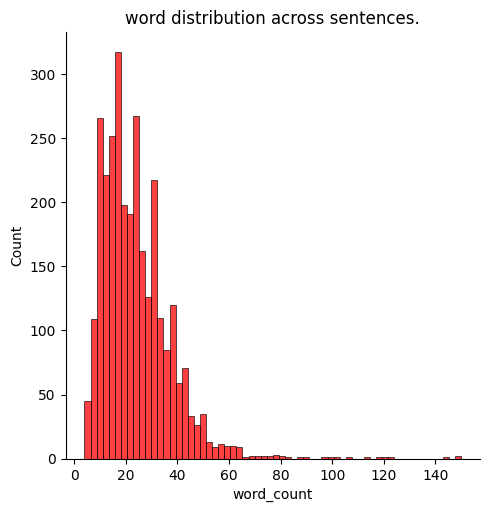

In [ ]:
#getting word count of each reviews
plt.figure(figsize=(3,3))
sns.displot(df_sub_interactions_final["word_count"], color = 'r')
plt.title('word distribution across sentences.')

#### **Label distribution**

y    1605
n    1395
Name: LABEL, dtype: int64


<Axes: >

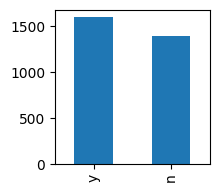

In [ ]:
print(df_sub_interactions_final["LABEL"].value_counts())
df_sub_interactions_final["LABEL"].value_counts().plot(kind='bar',figsize=(2,2))

#### **Predicate distribution**

INTERACTS_WITH    1781
STIMULATES         615
INHIBITS           604
Name: PREDICATE, dtype: int64


<Axes: >

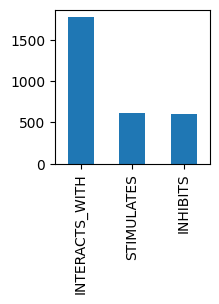

In [ ]:
print(df_sub_interactions_final["PREDICATE"].value_counts())
df_sub_interactions_final["PREDICATE"].value_counts().plot(kind='bar',figsize=(2,2))

#### **Label distribution with respect to Predicate**

y    1025
n     756
Name: LABEL, dtype: int64


<Axes: >

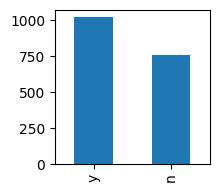

In [ ]:
print(df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "INTERACTS_WITH"]["LABEL"].value_counts())
df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "INTERACTS_WITH"]["LABEL"].value_counts().plot(kind = 'bar',figsize=(2,2))

n    358
y    257
Name: LABEL, dtype: int64


<Axes: >

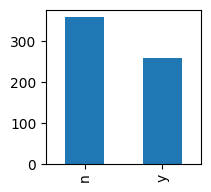

In [ ]:
print(df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "STIMULATES"]["LABEL"].value_counts())
df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "STIMULATES"]["LABEL"].value_counts().plot(kind = 'bar',figsize=(2,2))

y    323
n    281
Name: LABEL, dtype: int64


<Axes: >

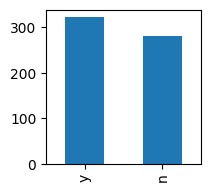

In [ ]:
print(df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "INHIBITS"]["LABEL"].value_counts())
df_sub_interactions_final.loc[df_sub_interactions_final.PREDICATE == "INHIBITS"]["LABEL"].value_counts().plot(kind = 'bar',figsize=(2,2))

In [ ]:
df_sub_interactions_final['Label'] = df_sub_interactions_final['LABEL'].apply(lambda x: 0 if x == "n" else 1)

<ipython-input-31-77b56834fb2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_interactions_final['Label'] = df_sub_interactions_final['LABEL'].apply(lambda x: 0 if x == "n" else 1)



### **Baseline Model**

In [ ]:
import wandb
%env WANDB_PROJECT="UMN_Baseline_Model"
wandb.login()

env: WANDB_PROJECT="UMN_Baseline_Model"


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:

def get_model_accuracy(ytest,ypred, param,flag = 0):
    accuracy_score = sklearn.metrics.accuracy_score(ytest, ypred)
    f1_score = sklearn.metrics.f1_score(ytest, ypred,average=param)
    recall_score = sklearn.metrics.recall_score(ytest, ypred,average=param)
    precision_score = sklearn.metrics.precision_score(ytest, ypred,average=param)
    print("accuracy: %f" % accuracy_score)
    print("f1_score: %f" % f1_score)
    print("recall_score: %f" % recall_score)
    print("precision_score: %f" % precision_score)
    if flag == 0:
        cf_matrix = confusion_matrix(ytest, ypred)
        sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                fmt='.2%', cmap='Blues')

In [ ]:
def add_tags(text, obj1, obj2):
    # Find the indices of obj1 and obj2 in the text
    index1 = text.find(obj1)
    index2 = text.find(obj2)

    # Insert the <e1> and </e1> tags around obj1
    text = text[:index1] + "<e1>" + obj1 + "</e1>" + text[index1+len(obj1):]

    # Since we added <e1> tag before obj2, the index of obj2 in the text is now shifted
    # by the length of the <e1> and </e1> tags
    index2 += len("<e1></e1>")

    # Insert the <e2> and </e2> tags around obj2
    text = text[:index2] + "<e2>" + obj2 + "</e2>" + text[index2+len(obj2):]

    return text


In [ ]:
# customized metric to generate accuracy,precision, recall, f1
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [ ]:
class subIntDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {key: torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
df_sub_interactions_final['sent_updated'] = df_sub_interactions_final.apply(lambda x: add_tags(x['SENTENCE'], x['SUBJECT_TEXT'], x['OBJECT_TEXT']), axis=1)
df_sub_interactions_final.head(3)

<ipython-input-32-d7840f06043e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_interactions_final['sent_updated'] = df_sub_interactions_final.apply(lambda x: add_tags(x['SENTENCE'], x['SUBJECT_TEXT'], x['OBJECT_TEXT']), axis=1)


,SENTENCE,SUBJECT_TEXT,OBJECT_TEXT,PREDICATE,LABEL,sent_updated,Label
0,"Nor did administration of SA, diflunisal or AS...",SA,ASA,INTERACTS_WITH,n,"Nor did administration of <e1>SA</e1>, difluni...",0
1,A comparative study of recombinant L-cha...,rHF,oxidase,INHIBITS,n,A comparative study of recombinant L-cha...,0
2,These findings suggest that some nicotinic alk...,alkaloids,aromatase,INHIBITS,y,These findings suggest that some nicotinic <e1...,1


In [ ]:
print("ORIGINAL SENTENCE: ",df_sub_interactions_final.loc[0,"SENTENCE"])
print("SENTENCE AFTER ENCODING: ",df_sub_interactions_final.loc[0,"sent_updated"])

ORIGINAL SENTENCE:  Nor did administration of SA, diflunisal or ASA itself impair the       anti-aggregatory effect of a fresh test dose of ASA.
SENTENCE AFTER ENCODING:  Nor did administration of <e1>SA</e1>, diflunisal or <e2>ASA</e2> itself impair the       anti-aggregatory effect of a fresh test dose of ASA.


In [ ]:
train_data,Y  = train_test_split(df_sub_interactions_final[["SENTENCE","sent_updated",'SUBJECT_TEXT',	'OBJECT_TEXT',	'PREDICATE',	"Label"	]], test_size = 0.3, stratify = df_sub_interactions_final.Label, random_state = 0)
val_data, test_data = train_test_split(Y, test_size = 0.5, stratify = Y.Label,random_state = 0)

In [ ]:
print(train_data.shape,val_data.shape,test_data.shape)

(2100, 6) (450, 6) (450, 6)


In [ ]:
#saving the distribution
train_data.to_csv("/content/drive/MyDrive/UMN/Data/train_data.csv", sep = "|", index = 0)
val_data.to_csv("/content/drive/MyDrive/UMN/Data/val_data.csv", sep = "|", index = 0)
test_data.to_csv("/content/drive/MyDrive/UMN/Data/test_data.csv", sep = "|", index = 0)

In [ ]:
train_labels = train_data["Label"].tolist()
val_labels = val_data["Label"].tolist()
test_labels = test_data["Label"].tolist()

train_data.drop('Label', axis=1, inplace=True)

val_data.drop('Label', axis=1, inplace=True)

test_data.drop('Label', axis=1, inplace=True)



In [ ]:
# Initialize the tokenizer and the BERT model
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'
tokenizer = AutoTokenizer.from_pretrained(model_name,additional_special_tokens=['<e1>', '</e1>', '<e2>', '</e2>'])
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

In [ ]:
#generating embeddings
train_encodings = tokenizer(train_data["sent_updated"].tolist(),train_data["PREDICATE"].tolist(), truncation=True, padding=True , max_length = 256)
val_encodings = tokenizer(val_data["sent_updated"].tolist(),val_data["PREDICATE"].tolist(), truncation=True, padding=True, max_length = 256)
test_encodings = tokenizer(test_data["sent_updated"].tolist(),test_data["PREDICATE"].tolist(), truncation=True, padding=True, max_length = 256)

In [ ]:
#generating dataset
train_dataset = subIntDataset(train_encodings, train_labels)
val_dataset = subIntDataset(val_encodings, val_labels)
test_dataset = subIntDataset(test_encodings, test_labels)


In [ ]:
#initialising the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',              # directory for storing logs
    evaluation_strategy = "epoch" ,
    save_strategy = "epoch",
    load_best_model_at_end=True,
    report_to="wandb",
    run_name="Baseline_model_v1",
    learning_rate = 2e-5,
    logging_steps=10,
    )


In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.625500,1.405172,0.635556,0.431535,0.793893,0.559140
2,0.407800,0.829053,0.651111,0.929461,0.615385,0.740496
3,0.456000,0.736488,0.775556,0.755187,0.812500,0.782796
4,0.447900,1.335639,0.717778,0.838174,0.696552,0.760829
5,0.110700,1.793677,0.731111,0.854772,0.705479,0.772983


TrainOutput(global_step=1315, training_loss=0.3162742497038252, metrics={'train_runtime': 170.3197, 'train_samples_per_second': 123.298, 'train_steps_per_second': 15.442, 'total_flos': 1214062242750000.0, 'train_loss': 0.3162742497038252, 'epoch': 5.0})

In [ ]:
#analysing evaluation metric
metrics=trainer.evaluate()
print(metrics)

{'eval_loss': 0.7364878058433533, 'eval_accuracy': 0.7755555555555556, 'eval_recall': 0.7551867219917012, 'eval_precision': 0.8125, 'eval_f1': 0.7827956989247312, 'eval_runtime': 4.1713, 'eval_samples_per_second': 107.88, 'eval_steps_per_second': 6.952, 'epoch': 5.0}


In [ ]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(450, 2) (450,)


In [ ]:
trainer.save_model("/content/drive/MyDrive/UMN/UMN-Final")

In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       210
           1       0.83      0.74      0.78       240

    accuracy                           0.78       450
   macro avg       0.78      0.78      0.78       450
weighted avg       0.79      0.78      0.78       450



accuracy: 0.780000
f1_score: 0.782418
recall_score: 0.741667
precision_score: 0.827907


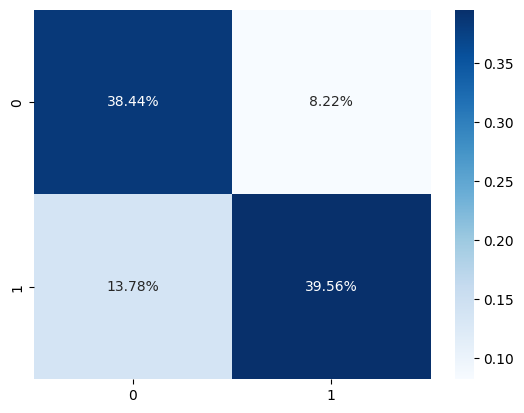

In [ ]:
get_model_accuracy(test_labels,preds, "binary",flag = 0)

In [ ]:
wandb.finish()

eval/accuracy,▄▂▇▄▁▂█▅▆█
eval/f1,▄▇█▄▁▇█▇██
eval/loss,▁▂▁▁▆▂▂▅█▂
eval/precision,█▁▆█▇▁█▄▄█
eval/recall,▂█▆▂▁█▅▇▇▅
eval/runtime,▁▂▃▃▅▂▆▁█▅
eval/samples_per_second,█▇▆▆▄▇▃█▁▄
eval/steps_per_second,█▇▆▆▄▇▃█▁▄
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/learning_rate,▁▂▂▃▄▅▅▆▇████▇▇▁▂▂▃▄▅▆▇▇███▇▇▇▇▇▇▆▆▆▆▆▅▅


### **SETFIT Model: As a few shot**

In [ ]:
# appending entities to original sentence as form of question
def adding_entities_as_sentence(SENTENCE,SUBJECT_TEXT,OBJECT_TEXT,PREDICATE):
  return SENTENCE+" "+"Does "+SUBJECT_TEXT+" "+PREDICATE+" "+OBJECT_TEXT+"?"

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/UMN/Data/train_data.csv", sep = "|")
val_data =  pd.read_csv("/content/drive/MyDrive/UMN/Data/val_data.csv", sep = "|")
test_data =  pd.read_csv("/content/drive/MyDrive/UMN/Data/test_data.csv", sep = "|")

In [ ]:
train_data['sent_ques'] = train_data.apply(lambda x: adding_entities_as_sentence(x.SENTENCE, x.SUBJECT_TEXT, x.OBJECT_TEXT,x.PREDICATE), axis=1)
val_data['sent_ques'] = val_data.apply(lambda x: adding_entities_as_sentence(x.SENTENCE, x.SUBJECT_TEXT, x.OBJECT_TEXT,x.PREDICATE), axis=1)
test_data['sent_ques'] = test_data.apply(lambda x: adding_entities_as_sentence(x.SENTENCE, x.SUBJECT_TEXT, x.OBJECT_TEXT,x.PREDICATE), axis=1)
train_data.loc[0,'sent_ques']

'The reversible inactivation of L-threonine hydratase of sheep liver by L-serine. Does L-serine INHIBITS hydratase?'

#### **Taking 20 examples for each combination of predicate and label from full train data**.
#### In total there are 3 predicates and 2 labels , so total 6 combinations.

In [ ]:
from sklearn.utils import shuffle

def generate_few_shot_dataset(train_data,n):
    df_int_n = train_data.loc[(train_data.PREDICATE == "INTERACTS_WITH") & (train_data.Label == 0)][0:n]
    df_int_y = train_data.loc[(train_data.PREDICATE == "INTERACTS_WITH") & (train_data.Label == 1)][0:n]
    df_stim_n = train_data.loc[(train_data.PREDICATE == "STIMULATES") & (train_data.Label == 0)][0:n]
    df_stim_y = train_data.loc[(train_data.PREDICATE == "STIMULATES") & (train_data.Label == 1)][0:n]
    df_inhi_n = train_data.loc[(train_data.PREDICATE == "INHIBITS") & (train_data.Label == 0)][0:n]
    df_inhi_y = train_data.loc[(train_data.PREDICATE == "INHIBITS") & (train_data.Label == 1)][0:n]
    df_few_shot = pd.concat([df_int_n,df_int_y,df_stim_n,df_stim_y,df_inhi_n,df_inhi_y])
    df_few_shot = shuffle(df_few_shot)
    df_few_shot.reset_index(drop=True, inplace = True)
    return df_few_shot

In [ ]:
df_few_shot_20 = generate_few_shot_dataset(train_data,20)

In [ ]:
train_df, X = train_test_split(df_few_shot_20, test_size=0.3, stratify=df_few_shot_20[["Label"]],random_state=15)
test_df,eval_df = train_test_split(X, test_size=0.5, stratify=X[["Label"]],random_state=15)
print(train_df.shape,eval_df.shape, test_df.shape)

(84, 7) (18, 7) (18, 7)


In [ ]:
train_df

,SENTENCE,sent_updated,SUBJECT_TEXT,OBJECT_TEXT,PREDICATE,Label,sent_ques
100,The effect of 5-fluorouracil on bacterial prot...,The effect of <e1>5-fluorouracil</e1> on <e2>b...,5-fluorouracil,bacterial protein,INTERACTS_WITH,1,The effect of 5-fluorouracil on bacterial prot...
46,Production of antibody was demonstrated ...,Production of antibody was demonstrated ...,precipitin,serum albumin,INHIBITS,0,Production of antibody was demonstrated ...
75,The attachment of BCG to purified FN in vitro ...,The attachment of BCG to purified FN in vit<e2...,anti-FN antibodies,FN,INHIBITS,0,The attachment of BCG to purified FN in vitro ...
79,The effect of anaesthetic agents on the cerebr...,The effect of anaesthet<e2>anaesthetic agents<...,sulphate,anaesthetic agents,INTERACTS_WITH,1,The effect of anaesthetic agents on the cerebr...
16,Human myocardial fatty acid ethyl ester syntha...,Human <e1>myocardial fatty acid ethyl ester sy...,myocardial fatty acid ethyl ester synthase-III,ethanol,INTERACTS_WITH,1,Human myocardial fatty acid ethyl ester syntha...
...,...,...,...,...,...,...,...
77,Northern blot analysis of polyA RNA prepared ...,Northern blot analysis of polyA RNA prepared ...,beta-naphthoflavone,1A1,STIMULATES,1,Northern blot analysis of polyA RNA prepared ...
7,An intraperitoneal injection of N-methyl...,An intraperitoneal injection of N-methyl...,aspartate,AP1,STIMULATES,1,An intraperitoneal injection of N-methyl...
73,"Kinetic analysis revealed that (1), the ...","Kinetic analysis revealed that (1), the ...",papain,phenylalanine,INTERACTS_WITH,0,"Kinetic analysis revealed that (1), the ..."
110,"YM-09538, a new sulfonamide-substituted phenyl...","YM-09538, a new sulfonamide-substituted <e1>ph...",phenylethylamine,beta 1-adrenoceptors,STIMULATES,0,"YM-09538, a new sulfonamide-substituted phenyl..."


In [ ]:
few_shot_train_dataset = Dataset.from_pandas(train_df[["sent_ques","Label"]])
few_shot_eval_dataset = Dataset.from_pandas(eval_df[["sent_ques","Label"]])
few_shot_test_dataset = Dataset.from_pandas(test_df[["sent_ques"]])

In [ ]:
# Initialising set-fit model
model = SetFitModel.from_pretrained("sentence-transformers/all-roberta-large-v1")


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


##### **Training a few-shot model with 20**

In [ ]:
trainer_few_shot = SetFitTrainer(
    model=model,
    train_dataset=few_shot_train_dataset,
    eval_dataset=few_shot_eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_epochs=2,
    column_mapping={"sent_ques": "text", "Label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
# Train and evaluate
trainer_few_shot.train()
metrics = trainer_few_shot.evaluate()
print(metrics)

Applying column mapping to training dataset
***** Running training *****
  Num examples = 3360
  Num epochs = 2
  Total optimization steps = 420
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/210 [00:00<?, ?it/s]

Iteration:   0%|          | 0/210 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7222222222222222}


##### **Evaluating against full test data that was used in Baseline Model**

In [ ]:
test_dataset = Dataset.from_pandas(test_data[["sent_ques"]])
pred_all = trainer_few_shot.model(test_dataset["sent_ques"])
target_all = test_data[["Label"]]

In [ ]:
print(classification_report(target_all,pred_all,target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.62      0.53      0.57       210
    positive       0.64      0.72      0.67       240

    accuracy                           0.63       450
   macro avg       0.63      0.62      0.62       450
weighted avg       0.63      0.63      0.63       450



accuracy: 0.631111
f1_score: 0.674510
recall_score: 0.716667
precision_score: 0.637037


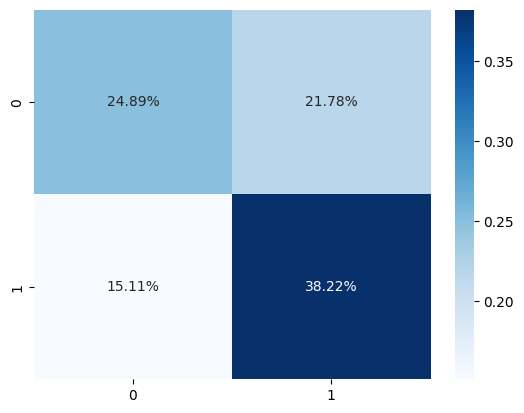

In [ ]:
get_model_accuracy(target_all,pred_all, "binary",flag = 0)

#### **Taking 150 examples for each combination of predicate and label from full train data**.
#### In total there are 3 predicates and 2 labels , so total 6 combinations.

In [ ]:
df_few_shot_150 = generate_few_shot_dataset(train_data,150)
df_few_shot_150

,SENTENCE,sent_updated,SUBJECT_TEXT,OBJECT_TEXT,PREDICATE,Label,sent_ques
0,It was relatively resistant to heat and to pen...,It was relatively resistant to heat and to pen...,antibiotics,penicillin,INHIBITS,0,It was relatively resistant to heat and to pen...
1,The baseline disposal of L-TRP was relat...,The baseline disposal of L-TRP was<e2>L-...,insulin,L-TRP,INHIBITS,0,The baseline disposal of L-TRP was relat...
2,The decreased PGF and PGE2 production as...,The decreased <e1>PGF</e1> and PGE2 prod...,PGF,indomethacin,INHIBITS,0,The decreased PGF and PGE2 production as...
3,Synthesis of nitric oxide from L-arginine: a r...,Synthesis of nitric oxide from L-arginin<e2>L-...,cytokines,L-arginine,STIMULATES,1,Synthesis of nitric oxide from L-arginine: a r...
4,Peptidyl chloromethane and sulphonium salts co...,Peptidyl chloromethane and sulphonium salts co...,Lys,prohormone,INHIBITS,0,Peptidyl chloromethane and sulphonium salts co...
...,...,...,...,...,...,...,...
895,"The degradation of one such species, H2O2, is ...","The degradation of one such species, H2O2, is ...",catalase,H2O2,INTERACTS_WITH,1,"The degradation of one such species, H2O2, is ..."
896,Enhancement by heated rabbit-serum of antihist...,Enhancement by heated <e1>rabbit-serum</e1> of...,rabbit-serum,antihistamine,STIMULATES,1,Enhancement by heated rabbit-serum of antihist...
897,A unifying hypothesis to explain these seeming...,A unifying hypothesis to explain these seeming...,alcohol,prolactin,STIMULATES,1,A unifying hypothesis to explain these seeming...
898,Tetralin hydroperoxide as an intermediate ...,Tetralin <e1>hydroperoxide</e1> as an intermed...,hydroperoxide,tetralin,INTERACTS_WITH,1,Tetralin hydroperoxide as an intermediate ...


In [ ]:
train_df, X = train_test_split(df_few_shot_150, test_size=0.3, stratify=df_few_shot_150[["Label"]],random_state=15)
test_df,eval_df = train_test_split(X, test_size=0.5, stratify=X[["Label"]],random_state=15)
print(train_df.shape,eval_df.shape, test_df.shape)

(630, 7) (135, 7) (135, 7)


In [ ]:
train_dataset_few_shot_150 = Dataset.from_pandas(train_df[["sent_ques","Label"]])
eval_dataset_few_shot_150 = Dataset.from_pandas(eval_df[["sent_ques","Label"]])
test_dataset_few_shot_150 = Dataset.from_pandas(test_df[["sent_ques"]])
train_dataset_few_shot_150

Dataset({
    features: ['sent_ques', 'Label', '__index_level_0__'],
    num_rows: 630
})

##### **Training a few-shot model with 150**

In [ ]:
trainer_few_shot_150 = SetFitTrainer(
    model=model,
    train_dataset=train_dataset_few_shot_150,
    eval_dataset=eval_dataset_few_shot_150,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_epochs=3,
    column_mapping={"sent_ques": "text", "Label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
# Train and evaluate
trainer_few_shot_150.train()
metrics = trainer_few_shot_150.evaluate()
print(metrics)

Applying column mapping to training dataset
***** Running training *****
  Num examples = 25200
  Num epochs = 3
  Total optimization steps = 4725
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1575 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.8518518518518519}


##### **Evaluating against full test data that was used in Baseline Model**

In [ ]:
test_dataset = Dataset.from_pandas(test_data[["sent_ques"]])
pred_all_150 = trainer_few_shot_150.model(test_dataset["sent_ques"])
target_all_150 = test_data[["Label"]]

In [ ]:
print(classification_report(target_all_150,pred_all_150,target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.73      0.64      0.68       210
    positive       0.72      0.79      0.75       240

    accuracy                           0.72       450
   macro avg       0.72      0.72      0.72       450
weighted avg       0.72      0.72      0.72       450



accuracy: 0.720000
f1_score: 0.750000
recall_score: 0.787500
precision_score: 0.715909


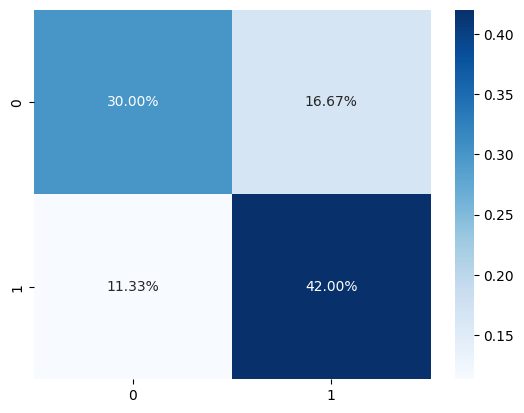

In [ ]:
get_model_accuracy(target_all_150,pred_all_150, "binary",flag = 0)